# Определение выгодного тарифа для телеком-компании

## 1 Описание проекта

**Задачи проекта:** Проанализировать поведение клиентов федерального сотового оператора «Мегалайн» за 2018 г. в рамкаха двух тарифных планов: «Смарт» и «Ультра» и сделать вывод — какой тарифный план выгоднее для компании.

**Данные для анализ:** выборка данных по 500 пользователей за 2018 г.

**Этапы проекта:** 
- [2 зучение и предобработка данных](#preprocessing)
- [3 расчёты и добавление результатов](#calculating)
- [4 исследовательский анализ данных](#correlation)
- [5 статистический анализ данных](#statistics)
- [6 аномальные пользователи](#anomalies)
- [7 проверка гипотез](#hypotheses)
- [8 общий вывод и рекомендации](#conclusion)

**Тарифы** (минуты и мегабайты округляются вверх до целого):

«Смарт»
- Ежемесячная плата: 550 рублей
- Включено: 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета: минута разговора 3 рубля, сообщение 3 рубля, 1 Гб интернет-трафика 200 рублей.

«Ультра»
- Ежемесячная плата: 1950 рублей
- Включено: 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета: минута разговора 1 рубль, сообщение 1 рубль, 1 Гб интернет-трафика 150 рублей.

<a id='preprocessing'></a>
## 2 Изучение и предобработка данных

In [1]:
# импортируем необходимые библиотеки и делаем настройки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from scipy import stats as st

pd.set_option('display.max_columns', None)

In [2]:
mb_to_gb = 1024 # задаем переменную для перевода Мб в Гб

# задаем переменные для тарифов
t1 = 'ultra' 
t2 = 'smart'

In [3]:
#через цикл загружаем датасеты, выводим первые 5 строк и читаем info
datasets = ['calls', 'internet', 'messages', 'tariffs', 'users']

for dataset in datasets:
    files = glob.glob(dataset + '.csv')
    for file in files:
        globals()[dataset] = pd.read_csv(file)
        print('----------------------------------\n', dataset, '\n----------------------------------')
        globals()[dataset].info()
        display(globals()[dataset].head())     

----------------------------------
 calls 
----------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


----------------------------------
 internet 
----------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


----------------------------------
 messages 
----------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


----------------------------------
 tariffs 
----------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


----------------------------------
 users 
----------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Проверим таблицу пользователей users на наличие дубликатов в столбце user_id.

In [4]:
print('Кол-во дубликатов в user_id:', users['user_id'].duplicated().sum())

Кол-во дубликатов в user_id: 0


Напишем пользовательскую функцию для обработки столбцов с датами, которая меняет формат данных с object на datetime.

In [5]:
def to_datetime(dataset, col):
    dataset[col] = pd.to_datetime(dataset[col], format='%Y-%m-%d') # изменяет формат данных на datetime

Через цикл применим написанную функцию к датасетам и столбцам из словаря и выведем на экран info().

In [6]:
date_cols = ({'calls' : 'call_date',
              'internet' : 'session_date',
              'messages' : 'message_date',
              'users': 'reg_date', 
              'users': 'churn_date'}
            )

for key in date_cols:
    to_datetime(globals()[key], date_cols[key])
    print('----------------------------------\n', key, '\n----------------------------------')
    globals()[key].info()

----------------------------------
 calls 
----------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB
----------------------------------
 internet 
----------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    149396 non-null  int64         
 1   id            149396 non-null  object        
 2   mb_used       149396 non-null  float64     

### 2.1 Вывод

На данном этапе были прочитаны и загружены 5 датасетов: 
- users – информация о пользователях,
- calls – информация о звонках,
- messages – информация о сообщениях,
- internet – информация об интернет-сессиях,
- tariffs – информация о тарифах.

Для всех таблиц по всем столбцам, содержащим дату, изменены форматы данных с object на datetime.

<a id='calculating'></a>
## 3 Расчёты и добавление результатов

Нам известно, что «Мегалайн» всегда округляет секунды до минут, а именно: каждый звонок округляется отдельно, даже если он длился всего 1 секунду, будет засчитан как 1 минута.   
Округлим каждый звонок до целых минут вверх.

In [7]:
calls['duration_rouned'] = np.ceil(calls['duration']).astype(int)

На основе таблицы звонков создадим новую таблицу – calls_grouped, где укрупним данные до месячных, рассчитав общее кол-во звонков и их продолжительность по месяцам по каждому абоненту.

In [8]:
calls_grouped = (calls.groupby(['user_id', pd.Grouper(key='call_date', freq='M')])
                      .agg(calls_qty = ('duration_rouned', 'count'), 
                           minutes_qty = ('duration_rouned', 'sum'))
                      .reset_index()
                )
calls_grouped.rename(columns = {'call_date' : 'month'}, inplace=True) # переименовываем столбец 'call_date' в 'month'
calls_grouped

,user_id,month,calls_qty,minutes_qty
0,1000,2018-05-31,22,159
1,1000,2018-06-30,43,172
2,1000,2018-07-31,47,340
3,1000,2018-08-31,52,408
4,1000,2018-09-30,58,466
...,...,...,...,...
3169,1498,2018-10-31,41,247
3170,1499,2018-09-30,9,70
3171,1499,2018-10-31,68,449
3172,1499,2018-11-30,74,612


На основе таблицы интернет-трафика создадим новую таблицу – internet_grouped, где укрупним данные до месячных, рассчитав общий дата-трафик в Гб по месяцам по каждому абоненту.    
При этом нам известно, что по итогам месяца «Мегалайн» округляет мегабайты до гигабайт в бо́льшую сторону.

In [9]:
internet_grouped = (internet.groupby(['user_id', pd.Grouper(key='session_date', freq='M')])
                            .agg({'mb_used': 'sum'})
                            .reset_index()
                   )

internet_grouped['gb_used'] = np.ceil(internet_grouped['mb_used'] / mb_to_gb).astype(int)
internet_grouped.rename(columns = {'session_date' : 'month'}, inplace=True) # переименовываем столбец 'session_date' в 'month'
internet_grouped

,user_id,month,mb_used,gb_used
0,1000,2018-05-31,2253.49,3
1,1000,2018-06-30,23233.77,23
2,1000,2018-07-31,14003.64,14
3,1000,2018-08-31,14055.93,14
4,1000,2018-09-30,14568.91,15
...,...,...,...,...
3198,1498,2018-10-31,20579.36,21
3199,1499,2018-09-30,1845.75,2
3200,1499,2018-10-31,17788.51,18
3201,1499,2018-11-30,17963.31,18


На основе таблицы SMS-сообщений создадим новую таблицу – messages_grouped, где укрупним данные до месячных, рассчитав общий кол-во сообщений по месяцам по каждому абоненту.

In [10]:
messages_grouped = (messages.groupby(['user_id', pd.Grouper(key='message_date', freq='M')])
                            .agg(messages_qty = ('id', 'count'))
                            .reset_index()
                   )

messages_grouped.rename(columns = {'message_date' : 'month'}, inplace=True) # переименовываем столбец 'message_date' в 'month'
messages_grouped

,user_id,month,messages_qty
0,1000,2018-05-31,22
1,1000,2018-06-30,60
2,1000,2018-07-31,75
3,1000,2018-08-31,81
4,1000,2018-09-30,57
...,...,...,...
2712,1498,2018-10-31,42
2713,1499,2018-09-30,11
2714,1499,2018-10-31,48
2715,1499,2018-11-30,59


Объединим все три фрейма – calls_grouped, internet_grouped, messages_grouped – в один методом merge() по 'user_id' и 'month'.

In [11]:
df = calls_grouped.merge(internet_grouped, on=['user_id', 'month'], how='outer').merge(messages_grouped, on=['user_id', 'month'], how='outer')
df.head()

,user_id,month,calls_qty,minutes_qty,mb_used,gb_used,messages_qty
0,1000,2018-05-31,22.0,159.0,2253.49,3.0,22.0
1,1000,2018-06-30,43.0,172.0,23233.77,23.0,60.0
2,1000,2018-07-31,47.0,340.0,14003.64,14.0,75.0
3,1000,2018-08-31,52.0,408.0,14055.93,14.0,81.0
4,1000,2018-09-30,58.0,466.0,14568.91,15.0,57.0


В объединенную таблицу добавим данные:
- о городе проживания абонента и о подключенном тарифном плане – из таблицы users,
- о составе и условиях тарифного плана – из таблицы tariffs.

In [12]:
df = pd.merge(df, users[['user_id', 'city', 'tariff']], how='right', on='user_id')
df = pd.merge(df, tariffs, how='left', left_on='tariff', right_on='tariff_name')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3216 non-null   int64         
 1   month                  3214 non-null   datetime64[ns]
 2   calls_qty              3174 non-null   float64       
 3   minutes_qty            3174 non-null   float64       
 4   mb_used                3203 non-null   float64       
 5   gb_used                3203 non-null   float64       
 6   messages_qty           2717 non-null   float64       
 7   city                   3216 non-null   object        
 8   tariff                 3216 non-null   object        
 9   messages_included      3216 non-null   int64         
 10  mb_per_month_included  3216 non-null   int64         
 11  minutes_included       3216 non-null   int64         
 12  rub_monthly_fee        3216 non-null   int64         
 13  rub

In [13]:
# Удалим лишний столбец 'tariff_name', появившийся при слиянии с таблицей tariffs

df = df.drop(columns='tariff_name')

Пустые значения в колонках с данными о трафике заменим на 0, поскольку это говорит о том, что в конкретном месяце абонент не пользовался определенным видом трафика: не разговаривал голосом, или не посылал сообщения, или не использовал мобильные данные.

In [14]:
isnull_col_list = ['calls_qty', 'minutes_qty', 'mb_used', 'gb_used', 'messages_qty']

for isnull_col in isnull_col_list:
    df[isnull_col] = df[isnull_col].fillna(0)
    
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3216 non-null   int64         
 1   month                  3214 non-null   datetime64[ns]
 2   calls_qty              3216 non-null   float64       
 3   minutes_qty            3216 non-null   float64       
 4   mb_used                3216 non-null   float64       
 5   gb_used                3216 non-null   float64       
 6   messages_qty           3216 non-null   float64       
 7   city                   3216 non-null   object        
 8   tariff                 3216 non-null   object        
 9   messages_included      3216 non-null   int64         
 10  mb_per_month_included  3216 non-null   int64         
 11  minutes_included       3216 non-null   int64         
 12  rub_monthly_fee        3216 non-null   int64         
 13  rub

Найдем абонентов с пустым значением в поле 'month' и посмотрим на данные о них в таблице 'users'.

In [15]:
df[df['month'].isnull()]

,user_id,month,calls_qty,minutes_qty,mb_used,gb_used,messages_qty,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
827,1128,NaT,0.0,0.0,0.0,0.0,0.0,Волжский,ultra,1000,30720,3000,1950,150,1,1
2335,1371,NaT,0.0,0.0,0.0,0.0,0.0,Омск,smart,50,15360,500,550,200,3,3


In [16]:
users[users['user_id'].isin(df[df['month'].isnull()]['user_id'])]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
128,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra
371,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart


Эти 2 абонента были зарегистрированы меньше месяца и по ним нет никакого трафика. Скорее всего они не активировали тариф, поэтому их можно исключить из анализа.

In [17]:
df = df.replace('NaT', np.nan)
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3215
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3214 non-null   int64         
 1   month                  3214 non-null   datetime64[ns]
 2   calls_qty              3214 non-null   float64       
 3   minutes_qty            3214 non-null   float64       
 4   mb_used                3214 non-null   float64       
 5   gb_used                3214 non-null   float64       
 6   messages_qty           3214 non-null   float64       
 7   city                   3214 non-null   object        
 8   tariff                 3214 non-null   object        
 9   messages_included      3214 non-null   int64         
 10  mb_per_month_included  3214 non-null   int64         
 11  minutes_included       3214 non-null   int64         
 12  rub_monthly_fee        3214 non-null   int64         
 13  rub

Добавим столбцы, где рассчитываем кол-во минут, Гб и сообщений, израсходованных абонентом сверх тарифного плана.

In [18]:
df['min_over_tariff'] = np.where(
    df['minutes_qty'] <= df['minutes_included'], 0, df['minutes_qty'] - df['minutes_included']
                                )

df['gb_over_tariff'] = np.where(
    df['gb_used'] <= df['mb_per_month_included'] / mb_to_gb, 0, df['gb_used'] - df['mb_per_month_included'] / mb_to_gb
                                )

df['messages_over_tariff'] = np.where(
    df['messages_qty'] <= df['messages_included'], 0, df['messages_qty'] - df['messages_included']
                                    )

df.head()

,user_id,month,calls_qty,minutes_qty,mb_used,gb_used,messages_qty,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,min_over_tariff,gb_over_tariff,messages_over_tariff
0,1000,2018-05-31,22.0,159.0,2253.49,3.0,22.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0
1,1000,2018-06-30,43.0,172.0,23233.77,23.0,60.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0
2,1000,2018-07-31,47.0,340.0,14003.64,14.0,75.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0
3,1000,2018-08-31,52.0,408.0,14055.93,14.0,81.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0
4,1000,2018-09-30,58.0,466.0,14568.91,15.0,57.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0


Рассчитываем сумму, потраченную абонентами по месяцам, исходя из месячной абонентской платы за тариф и тарифов на сверхлимитные минуты, Гб и сообщения. 

In [19]:
df['income'] = ( 
                df['min_over_tariff'] * df['rub_per_minute']
                + df['gb_over_tariff'] * df['rub_per_gb']
                + df['messages_over_tariff'] * df['rub_per_message']
                + df['rub_monthly_fee']
               )
df.head()

,user_id,month,calls_qty,minutes_qty,mb_used,gb_used,messages_qty,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,min_over_tariff,gb_over_tariff,messages_over_tariff,income
0,1000,2018-05-31,22.0,159.0,2253.49,3.0,22.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
1,1000,2018-06-30,43.0,172.0,23233.77,23.0,60.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
2,1000,2018-07-31,47.0,340.0,14003.64,14.0,75.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
3,1000,2018-08-31,52.0,408.0,14055.93,14.0,81.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
4,1000,2018-09-30,58.0,466.0,14568.91,15.0,57.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0


### 3.1 Вывод

В рамках данного этапа был создан общий фрейм данных, содержащий в себе:
- данные об абонентах (город проживания и подключенный тарифный план); 
- суммарные данные об объемах трафика (минуты, Гб, SMS), потребленного абонентами в месяц;
- состав тарифного плана;
- объем сверхлимитного потребления трафика и выручка по месяцам с каждого абонента.

<a id='correlation'></a>
## 4 Исследовательский анализ данных

### 4.1 Анализ методом describe()

Применим метод describe() для каждого из тарифов (t1 – ultra, t2 – smart), чтобы оценить основные статистические характеристики данных.

In [20]:
df.query('tariff == @t1')[['minutes_qty', 'gb_used', 'messages_qty', 'income']].describe() 

,minutes_qty,gb_used,messages_qty,income
count,985.000000,985.000000,985.000000,985.000000
mean,526.623350,19.494416,49.363452,2070.152284
std,317.606098,9.853511,47.804457,376.187114
min,0.000000,0.000000,0.000000,1950.000000
25%,284.000000,12.000000,6.000000,1950.000000
50%,518.000000,19.000000,38.000000,1950.000000
75%,752.000000,27.000000,79.000000,1950.000000
max,1673.000000,49.000000,224.000000,4800.000000


In [21]:
df.query('tariff == @t1')['user_id'].nunique()

148

**Тариф Ultra:**
- В выборке 148 абонентов тарифа Ultra;


- *Минуты*: абоненты в среднем говорят по 527 мин в мес. Максимум, который достигали абоненты составляет 1673 мин за мес. Учитывая, что тарифный план включает 3000 мин, можно сказать, что даже самый разговорчивый абонент, расходует максимум только половину лимита;


- *Гигабайты*: абоненты в среднем используют 19.5 Гб мобильного трафика. Бывают периоды, когда абоненты не пользуются мобильными данными, но бывает, что трафик достигает 49 Гб за мес. Учитывая, что тарифный пакет включает 30 Гб, а в 75% случаев абоненты используют не больше 27 Гб в мес, можно сказать, что очень малому числу абонентов не хватает пакетного лимита;


- *Собщения*: абоненты в среднем отправляют в месяц 49 SMS, но есть и такие, которые совсем не пользуются SMS, и такие, которые отправляют по 224 SMS в месяц. 1000 SMS тарифного плана – более, чем достаточно;


- *Выручка с абонентов*: в среднем каждый абонент в месяц платит 2070 р. за пользование тарифом. В 75% случаев абоненты остаются в рамках тарифного плана и платят 1950 р. в месяц, хотя случается, что абоненты платят по 4800 р. за мес.

In [22]:
df.query('tariff == @t2')[['minutes_qty', 'gb_used', 'messages_qty', 'income']].describe()  

,minutes_qty,gb_used,messages_qty,income
count,2229.000000,2229.000000,2229.000000,2229.000000
mean,417.934948,16.328847,33.384029,1289.973531
std,190.313730,5.747061,28.227876,818.404367
min,0.000000,0.000000,0.000000,550.000000
25%,282.000000,13.000000,10.000000,550.000000
50%,422.000000,17.000000,28.000000,1023.000000
75%,545.000000,20.000000,51.000000,1750.000000
max,1435.000000,38.000000,143.000000,6770.000000


In [23]:
df.query('tariff == @t2')['user_id'].nunique()

350

**Тариф Smart:**
- В выборке 350 абонентов тарифа Smart;


- *Минуты*: абоненты в среднем говорят по 418 мин в мес. Бывают месяцы, когда абоненты не пользуются голосовым трафиком, а бывает, что выговаривают почти 1435 мин. Тарифный план включает 500 мин и хватает их только примерно в 70% случаев, значит остальные 30% будут стабильно со сверхлимитом по минутам;


- *Гигабайты*: абоненты в среднем используют 16.3 Гб мобильного трафика, но случается, что объем потребленного трафика достигает 38 Гб в мес. Тарифный план включает 15 Гб, их хватает только в 30% случаев, остальные 70% со стабильным сверхлимитом по Гб;


- *Сообщения*: абоненты в среднем отправляют в месяц 33 SMS, но есть, кто совсем не пользуется SMS, и кто отправляет по 143 SMS в месяц. Тарифный план включает 50 SMS – в 75% случаях этого кол-ва достаточно;


- *Выручка с абонентов*: в среднем каждый абонент в месяц платит 1290 р. за пользование тарифом. Учитывая размер абонентской платы в 550 р., получается, что каждый абонент в среднем переплачивает в 2.3 раза. Есть абоненты, которые остаются в рамках тарифного пакета, но их мало, а есть такие, которые заплатили 6770 р./мес, что в 12 раз превышает абонентскую плату.

**Сравнение абонентов Ultra и Smart:**

- *Кол-во пользователей*: пользователей тарифа Smart в 2.4 раза больше, чем пользователей тарифа Ultra (при условии, что структура выборки соответствует структуре генеральной совокупности);


- *Минуты*: абоненты тарифа Ultra в среднем в месяц говорят на 109 мин больше, чем абоненты Smart, но абонентам Ultra пакетного лимита более, чем достаточно, в то время как абоненты Smart в 30% случаев превышают пакетный лимит по минутам;


- *Гигабайты*: абоненты тарифа Ultra в среднем в месяц используют на 3.2 Гб больше, чем абоненты Smart, но абонентам Ultra в массе пакетного лимита достаточно, в то время как абоненты Smart в 70% случаев превышают пакетный лимит;


- *Сообщения*: абоненты тарифа Ultra пользуются SMS чаще, чем абоненты Smart, но их лимит им это позволяет более чем, в то время как у абонентов Smart лимит на SMS очень низкий, и в 25% случаев они уходят в перерасход;


- *Выручка с абонентов*: абоненты тарифа Ultra в среднем в месяц платят больше, но при этом большинство остаются в рамках абонентской платы за тариф, в то время, как абоненты Smart в массе выходят на сверхлимит и платят сумму, в среднем в 2.3 раза превышающую абонентскую плату.

### 4.2 Анализ с использованием боксплотов

Посторим боксплоты для анализируемых параметров в разрезе тарифных планов, чтобы оценить их визуально.

Для этого сначала "пересоберем" таблицу о тарифах, чтобы удобнее было на нее ссылаться.

In [24]:
tariffs_t = tariffs.set_index('tariff_name').T
tariffs_t.loc['gb_per_month_included', :] = tariffs_t.loc['mb_per_month_included', :] / mb_to_gb
tariffs_t

tariff_name,smart,ultra
messages_included,50.0,1000.0
mb_per_month_included,15360.0,30720.0
minutes_included,500.0,3000.0
rub_monthly_fee,550.0,1950.0
rub_per_gb,200.0,150.0
rub_per_message,3.0,1.0
rub_per_minute,3.0,1.0
gb_per_month_included,15.0,30.0


Создадим списки и словари, которые будем использовать при построении графиков.

In [25]:
tariffs_list = [t1, t2] # список тарифов

metrics_dict = {'minutes_qty': 'minutes_included', # словарь соответствия анализируемых параметров и тарифных лимитов на них
                 'gb_used': 'gb_per_month_included',
                 'messages_qty': 'messages_included',
                 'income': 'rub_monthly_fee'}

palettes = ['Blues', 'Greens'] # список цветовых палитр для графиков 

Напишем пользовательскую функцию для построения боксплотов.

In [26]:
def boxplot(dataset, metrica): # функция 2-х аргументов – датасет и анализируемый параметр
    title_pad = 2 # отступ заголовка графика по вертикали
    title_size = 10 # размер заголовка графика
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize = (8, 5)) # задаем параметры фигуры построения графиков
    count = 0 
    for i in range(2): # перебираем тарифы из списка
        ax = sns.boxplot(data=dataset[dataset['tariff'] == tariffs_list[count]], # строим для каждого тарифа отдельный график
                         x=metrica,
                         ax=axes[i],
                         palette=palettes[count]
                        )
        ax.set_title('тариф ' + tariffs_list[count], loc='right', pad=title_pad, size=title_size) # задаем заголовок графика 
        ax.axvline(x=tariffs_t.loc[metrics_dict.get(metrica), tariffs_list[count]], linestyle='--', color='brown') # строим вертикальные линии с тарифными лимитами для соответствующей метрики
        count += 1
    plt.suptitle('Боксплот для ' + metrica, size=14) # задаем заголовок фигуры
    plt.show()    

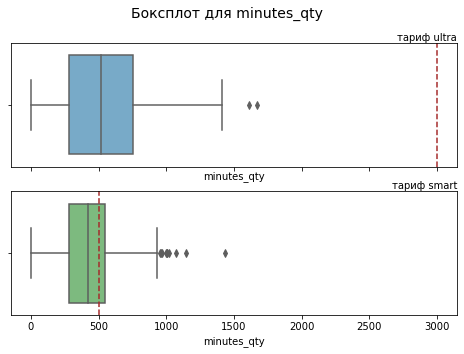

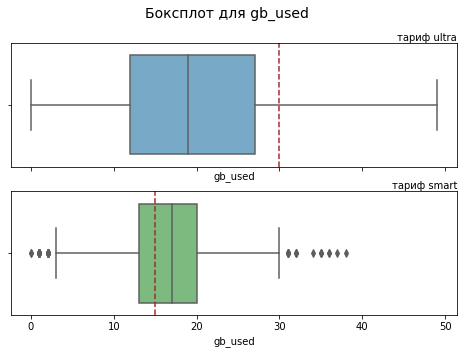

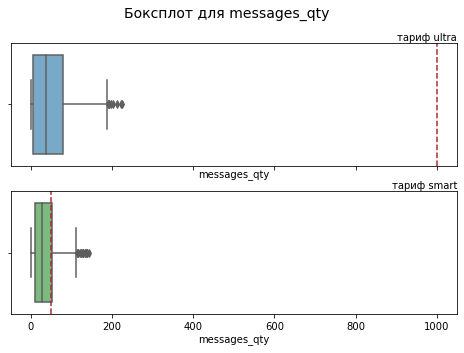

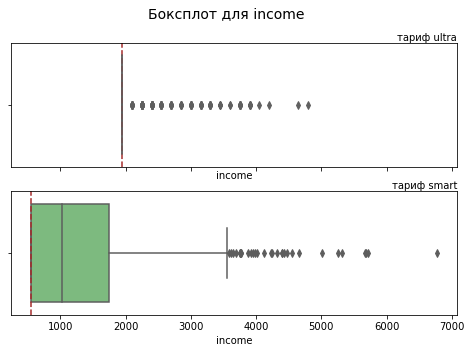

In [27]:
# запускаем перебор параметров из словаря и строим графики с помощью созданной функции boxplot(dataset, metrica)
for keys in metrics_dict:
    boxplot(df, keys) 

По боксплотам видна следующая картина (красные пунктирные линии на боксплотах – это лимиты трафика в рамках тарифного плана): 

- Различия среди абонентов тарифа Ultra по объему потребляемого трафика (минуты, Гб, SMS) больше, чем среди абонентов тарифа Smart – диапазоны "ящиков" у тарифа Ultra шире – это логично, потому что тарифные лимиты Ultra позволяют абонентам чувствовать себя свободнее.

     
- При этом границы лимитов тарифа Ultra настолько большие, что в 75% случаев (правая граница "ящика") абоненты не достигают этих лимитов. Лимитов по минутам и SMS не достигают даже выбросы за границы "усов", т.е. потребности абонентов в разы меньше, чем предоставленные тарифом лимиты. По Гб лимит удовлетворяет потребностям абонентов примерно в 80% случае. Т.е. в тарифе Ultra в сверхлимитное потребление уходят в очень редких случаях и только по интернет-трафику.


- Границы лимитов тарифа Smart намного меньше: по минутам лимита достаточно только в 70% случаев, по Гб – только примерно в 30% случаев, по SMS – в 75% случаев. Т.е. в тарифе Smart сверхлимитное потребление является регулярным, значительным и касается всех видов потребляемого трафика.


- По оплате мы видим, что практически все абоненты Ultra платят фиксированную абонентскую плату, за исключением нескольких аномальных случаев, когда было превышение по Гб. В то время как абоненты тарифа Smart остаются в рамках стандартной абонентской платы только в 25% случаев, а из-за высокой стоимости сверхлимита абоненты этого тарифа в 25% случаев вынуждены платить сумму, которая оказывается даже выше абон.платы тарифа Ultra, в итоге мы наблюдаем выбросы, которые уходят гораздо дальше, чем в тарифе Ultra.

### 4.3 Анализ сводных показателей

- Создадим сводную таблицу, где в разрезе тарифных планов рассчитаем сумму и среднюю по минутам, Гб, SMS и доходу с абонентов.
- На основе полученной сводной таблицы рассчитаем два новых показателя: доход с абонентов на 1 минуту и доход на 1 Гб.
- Затем рассчитаем соотношение между показателями тарифа Ultra и тарифа Smartа (на сколько % показатели тарифа Ultra больше или меньше показателей тарифа Smart).

In [28]:
agg_data = df.pivot_table(columns='tariff',
                                   values=['minutes_qty', 'gb_used', 'messages_qty', 'income'],
                                   aggfunc=('sum', 'mean')
                                  ) # сводная таблица 

agg_data.index = agg_data.index.map('_'.join) # "схлопываем" мультииндекс

agg_data.loc['income_per_min', :] = agg_data.loc['income_sum', :] / agg_data.loc['minutes_qty_sum', :] # выручка на минуту
agg_data.loc['income_per_gb', :] = agg_data.loc['income_sum', :] / agg_data.loc['gb_used_sum', :] # выручка на Гб
agg_data['tariffs_ratio%'] = (agg_data['ultra'] / agg_data['smart'] - 1) * 100 # соотношение тарифов в % 
agg_data.style.format('{:.1f}') 

tariff,smart,ultra,tariffs_ratio%
gb_used_mean,16.3,19.5,19.4
gb_used_sum,36397.0,19202.0,-47.2
income_mean,1290.0,2070.2,60.5
income_sum,2875351.0,2039100.0,-29.1
messages_qty_mean,33.4,49.4,47.9
messages_qty_sum,74413.0,48623.0,-34.7
minutes_qty_mean,417.9,526.6,26.0
minutes_qty_sum,931577.0,518724.0,-44.3
income_per_min,3.1,3.9,27.4
income_per_gb,79.0,106.2,34.4


На основе полученных данных видно следующее:

- Потребление минут и Гб в среднем на одного абонента в месяц у тарифа Ultra выше, чем у тарифа Smart на 26% (minutes_qty_mean) и 19% (gb_used_mean) соответственно, т.е. абоненты Ultra дают большую нагрузку на сеть. Но повышенная нагрузка существенно перекрывается более высокой доходностью абонентов Ultra – на 60% выше, чем у абонентов Smart (income_mean).  


- Дополнительные показатели – выручка на 1 минуту и выручка на  1 Гб – также демонстрируют более высокую доходность тарифа Ultra – примерно на 30% эти показатели у тарифа Ultra выше, чем у тарифа Smart.

### 4.4 Анализ показателей структуры

Посмотрим на структуру абонентов и выручки в разрезе тарифных планов.

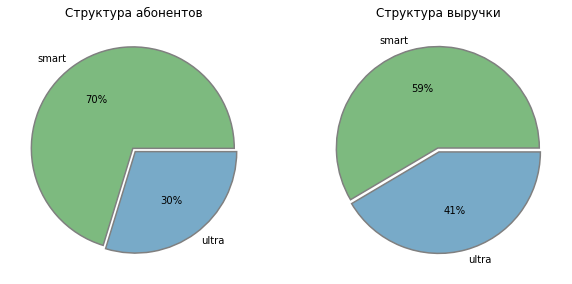

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (10, 5))

# визуальные настройки графиков
title_size = 12 # размер шрифта заголовков
colors = ['#7DBA7F', '#78AAC8'] # цвета секторов
wedgeprops = {'edgecolor':'gray', 'linewidth': 1.5} # цвет и толщина границы секторов
labels = df.groupby('tariff').agg({'income': 'sum'}).reset_index()['tariff'] # подписи сектров

axes[1].pie(df.groupby('tariff').agg({'income': 'sum'}).reset_index()['income'],
             labels=labels,    
             autopct="%0.0f%%",
             startangle=0,
             explode=[0.02]*2,
             colors=colors,
             wedgeprops=wedgeprops
            )
axes[1].set_title('Структура выручки', size=title_size)

axes[0].pie(df.groupby('tariff').agg({'user_id': 'nunique'}).reset_index()['user_id'],
             labels=labels,     
             autopct="%0.0f%%",
             startangle=0,
             explode=[0.02]*2,
             colors=colors,
             wedgeprops=wedgeprops
            )
axes[0].set_title('Структура абонентов', size=title_size)

plt.show()

Посмотрим на структуру выручки каждого из тарифов в разрезе того, какую долю составляет ежемесячная оплата пакета, а какую оплата сверх пакетных лимитов.

In [30]:
agg_income = df.groupby('tariff').agg({'income': 'sum', 'rub_monthly_fee': 'sum'}).reset_index()

agg_income['difference'] = agg_income['income'] - agg_income['rub_monthly_fee']
agg_income['difference%'] = round(agg_income['rub_monthly_fee'] / agg_income['income'] * 100, ndigits=1)
agg_income

,tariff,income,rub_monthly_fee,difference,difference%
0,smart,2875351.0,1225950,1649401.0,42.6
1,ultra,2039100.0,1920750,118350.0,94.2


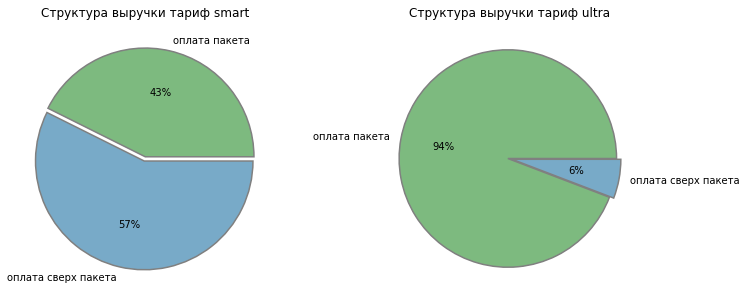

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (12, 5))

# визуальные настройки графиков
title_size = 12 # размер шрифта заголовков
colors = ['#7DBA7F', '#78AAC8'] # цвета секторов
wedgeprops = {'edgecolor':'gray', 'linewidth': 1.5} # цвет и толщина границы секторов
labels = ['оплата пакета', 'оплата сверх пакета'] # подписи сектров

count = 0
for i in range(2):
    axes[i].pie(agg_income.loc[i, 'rub_monthly_fee':'difference'],
                labels=labels,    
                autopct="%0.0f%%",
                startangle=0,
                explode=[0.02]*2,
                colors=colors,
                wedgeprops=wedgeprops
                )
    axes[i].set_title('Структура выручки тариф ' + agg_income.loc[i, 'tariff'], size=title_size)
    count += 1

plt.show()  

На графиках видно следующее: 

- Доля тарифа Ultra в структуре выручки больше, чем в структуре абонентов, т.е. это наглядно демонстрирует более высокую доходность абонентов Ultra по сравнению со Smart.

- 57% общей выручки тарифа Smart приходится на оплату сверхлимитного трафик, в то время, как у тарифа Ultra эта доля всего 6%.

### 4.5 Вывод

По данным, полученным на этом этапе, видна следующая картина:

> Абоненты тарифа Ultra потребляют больше трафика, чем абоненты Smart: на 26% больше по минутам и 19% больше по Гб, но приносят и больше выручки – в среднем в месяц один абонет Ultra приносит на 60% больше выручки, чем абонент Smart.


> Практически все абоненты Ultra остаются в рамках лимитов их тарифа, выход за рамки происходит лишь по интернет-трафику и только в 20% случаев. Лимиты по минутам и SMS настолько большие, что за весь год не были достигнуты ни разу. Это позволяет абонентам данного тарифа в большинстве случаев оставаться в рамках абонентской платы – 1950 р. Лимиты тарифного плана Ultra в разы больше лимитов Smart: минуты в 6 раз, Гб в 2 раза, SMS в 200 раз.


> Абоненты тарифа Smart только в 25% случаев остаются в рамках лимитов тарифного плана и платят 550 р. Лимиты тарифа маленькие, поэтому сверхлимитное потребление является постоянным и касается всех видов потребляемого трафика, особенно часто выходят на сверхлимит по Гб – в 70% случаев. В итоге в 75% случаев абоненты Smart платят сверх 550 р. А учитывая тот факт, что стоимость услуг сверх тарифного пакета у Smart выше, чем у Ultra, то в 25% случаев абоненты платят в месяц сумму, превышающую даже абон.плату тарифа Ultra. Оплата сверхлимитного трафика у абонентов Smart составляет почти 60% общей выручки данного тарифа.

<a id='statistics'></a>
## 5 Статистический анализ данных

Сгруппируем датафрейм по тарифным планам и рассчитаем для каждого тарифного плана среднюю, медиану, дисперсию и стандартное отклонение.

In [32]:
stat_data = df.pivot_table(columns='tariff',
                           values=['minutes_qty', 'gb_used', 'messages_qty', 'income'],
                           aggfunc=('mean', 'median', 'var', 'std')
                          )
                                 
stat_data

tariff                       smart          ultra
gb_used      mean        16.328847      19.494416
             median      17.000000      19.000000
             std          5.747061       9.853511
             var         33.028705      97.091686
income       mean      1289.973531    2070.152284
             median    1023.000000    1950.000000
             std        818.404367     376.187114
             var     669785.708006  141516.745079
messages_qty mean        33.384029      49.363452
             median      28.000000      38.000000
             std         28.227876      47.804457
             var        796.812958    2285.266143
minutes_qty  mean       417.934948     526.623350
             median     422.000000     518.000000
             std        190.313730     317.606098
             var      36219.315784  100873.633397

### 5.1 Вывод
По полученным на этом этапе данным можно сказать следующее:
- средние и медианы по минутам и Гб в обоих тарифах находятся близко относительно друг друга, что позволяет гворить о распределении данных как о близком к нормальному;  


- средние по SMS и доходам с абонентов в обоих тарифах несколько превышают их медианы, и по боксплотам мы это видим – распределения смещены влево и есть "хвосты" высоких значений, которые сдвигают среднюю вправо относительно медианы;


- значения стандартных отклонений по всем видам потребляемого трафика в тарифе Ultra существенно выше, чем в тарифе Smart – это мы видели на боксплотах – "ящики" и "усы" у тарифа Ultra шире, чем у тарифа Smart;


- значение стандартного отклонения по доходам с абонентов тарифа Ultra в 2 раза меньше, чем Smart – это также видно на боксплотах – практически все абоненты Ultra укладываются в лимиты и остаются в рамках абонентской платы, в то время как абоненты Smart имеют большой размах.

<a id='anomalies'></a>
## 6 Аномальные пользователи

Рассчитаем верхнюю и нижнюю границы аномальных значений (выбросов) для всех анализируемых параметров, а также количество и долю этих значений. Верхнюю и нижнюю границы определим как 1.5 межквартильного размаха.  

Для расчета указанных показателей напишем пользовательскую функцию.

In [33]:
def anomalies(dataset, col): # функция 2-х аргументов: датасет и параметр
    q = np.percentile(dataset[col], [25, 75]) # находим границы 1-го и 3-го квартиля (25% и 75% соответственно)
    top = q[1] + (q[1] - q[0]) * 1.5 # рассчитываем  значение верхнего "уса"
    bottom = np.where(q[0] < (q[1] - q[0]) * 1.5, dataset[col].min(), q[0] - (q[1] - q[0]) * 1.5) # значение нижнего "уса"
    anomalies_qty = len(dataset.loc[(dataset[col] < bottom) | (dataset[col] > top)]) # кол-во выбросов за границы "усов"
    anomalies_ratio = round((anomalies_qty / len(dataset)) * 100, ndigits=1) # доля выбросов в выборке
    values_list = [top, bottom, anomalies_qty, anomalies_ratio] # оборачиваем получаемые значения в список
    return values_list

In [34]:
# запускаем перебор параметров из списка 
# и для каждого тарифного плана определяем верхнюю и нижнюю границы аномальных значений,
# а также количество и долю этих значений с помощью созданной функции anomalies(dataset, col)

filter_col_list = ['minutes_qty', 'gb_used', 'messages_qty']

for tariff in tariffs_list:
    result = []
    for filter_col in filter_col_list:
        values = anomalies(df.query('tariff == @tariff'), filter_col)
        result.append(values)
    columns_list = ['top', 'bottom', 'anomalies_qty', 'anomalies_ratio%']    
    globals()[tariff] = pd.DataFrame(result, index=filter_col_list, columns=columns_list)
    print('------\n', tariff, '\n------')
    display(globals()[tariff])

------
 ultra 
------


,top,bottom,anomalies_qty,anomalies_ratio%
minutes_qty,1454.0,0.0,2,0.2
gb_used,49.5,0.0,0,0.0
messages_qty,188.5,0.0,8,0.8


------
 smart 
------


,top,bottom,anomalies_qty,anomalies_ratio%
minutes_qty,939.5,0.0,10,0.4
gb_used,30.5,2.5,53,2.4
messages_qty,112.5,0.0,14,0.6


В тарифе Ultra всего 10 аномальных значений: 2 по минутам и 8 по SMS.   
В тарифе Smart 77 аномальных значений, из них 10 по минутам, 53 по Гб, 14 по SMS.  
Но есть вероятность, что какие-то аномальные значения пересекаются. После очистки датасета от аномалий посчитаем кол-во отфильтрованных значений.

In [35]:
# фильтруем датасет по границам аномальных значений

filtered_t1 = df[(df['tariff'] == t1)
                & (df['minutes_qty'] <= globals()[t1].loc['minutes_qty', 'top'])
                & (df['minutes_qty'] >= globals()[t1].loc['minutes_qty', 'bottom'])
                & (df['gb_used'] <= globals()[t1].loc['gb_used', 'top'])
                & (df['gb_used'] >= globals()[t1].loc['gb_used', 'bottom'])
                & (df['messages_qty'] <= globals()[t1].loc['messages_qty', 'top'])
                & (df['messages_qty'] >= globals()[t1].loc['messages_qty', 'bottom'])
                ]

filtered_t2 = df[(df['tariff'] == t2)
                & (df['minutes_qty'] <= globals()[t2].loc['minutes_qty', 'top'])
                & (df['minutes_qty'] >= globals()[t2].loc['minutes_qty', 'bottom'])
                & (df['gb_used'] <= globals()[t2].loc['gb_used', 'top'])
                & (df['gb_used'] >= globals()[t2].loc['gb_used', 'bottom'])
                & (df['messages_qty'] <= globals()[t2].loc['messages_qty', 'top'])
                & (df['messages_qty'] >= globals()[t2].loc['messages_qty', 'bottom'])
                ]

df_filtered = filtered_t1.append(filtered_t2)    
df_filtered.shape

(3129, 20)

In [36]:
print('кол-во аномальных значений: ', len(df) - len(df_filtered))
print('доля аномальных значений: ', '{0:.1f}%'.format((1 - len(df_filtered) / len(df)) * 100))

кол-во аномальных значений:  85
доля аномальных значений:  2.6%


В ходе фильтрации выбросов ушло 85 аномальных значений или 2.6% от исходного размера датасета.

На основе очищенных данных построим гистограммы распределения для анализируемых параметров в разрезе тарифных планов.

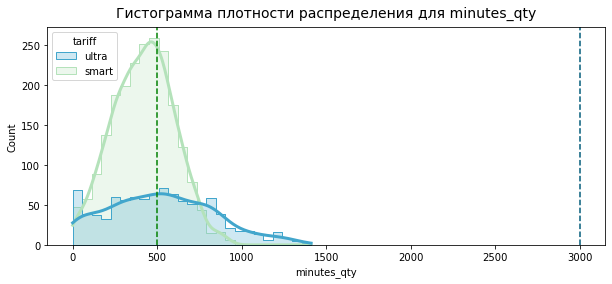

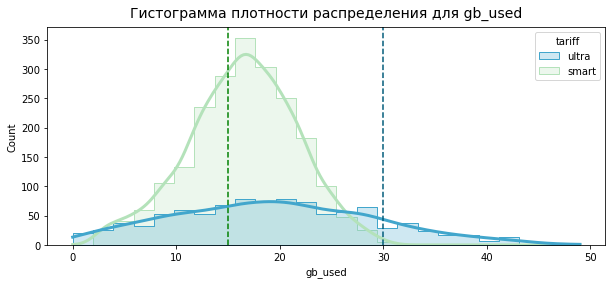

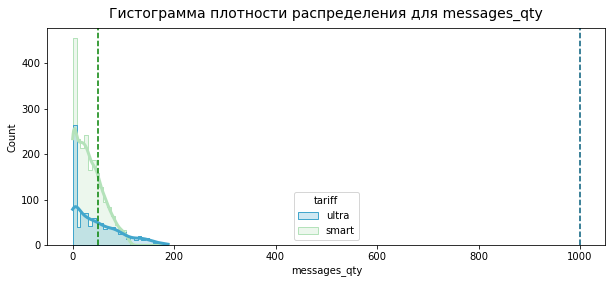

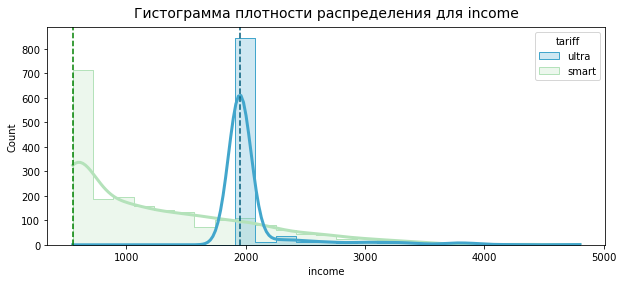

In [37]:
colors = ['#005B79', 'green']

for keys in metrics_dict:
    plt.figure(figsize=(10, 4))
    sns.histplot(data=df_filtered,
                 x=keys,
                 hue='tariff',
                 bins=25,
                 palette='GnBu_r',
                 kde=True,
                 element='step',
                 line_kws={'lw': 3},
                 hue_order=tariffs_list
                )
    count = 0
    for tariff in tariffs_list:
         # строим вертикальные линии с тарифными лимитами для соответствующей метрики
        plt.axvline(x=tariffs_t.loc[metrics_dict.get(keys), tariff], linestyle='--', color=colors[count])
        count += 1
    plt.title('Гистограмма плотности распределения для ' + keys, size=14, pad=10)
    plt.show()

### 6.1 Вывод

На данном этапе было выполнено сделующее:
>- определены границы аномального потребления трафика в месяц на основе бокс плотов – то, что выходит за границы 1.5 межквартильных размаха;
>- по этим границам отфильтрованы аномальные значений: всего 85 занчений – 2.6% от размера исходного дата фрейма;
>- по очищенному от аномалий дата фрейму построены гистограммы плотности распределения. 

Гистограммы позволили увидеть следующее:

> *Потребление минут и Гб у обоих тарифных планов распределено нормально и близко к симметричному.*
>- **У тарифа Smart** вершины куполов (т.е. значения средней и медианы нормального распределения), практически совпадают с лимитами, устоновленными тарифом для данных видов трафика (вертикальные пунктирные линии). Т.е. после ухода аномалий видно, что лимиты по минутам и Гб являются характеристикой среднего абонента Smart.
>- **У тарифа Ultra** границы лимитов далеко вправо отстоят от вершин куполов, особенно по минутам, где граница лимита даже не пересекает график распределения. Можно предположить, что тариф формировался с условием покрыть потребности даже самого активного пользователя, как по минутам, так и по Гб. Возможно, со временем структура потребления изменилась в пользу Гб (чему могло способствовать увеличение скорости интернет-трафика – абоненты общаются через голосовые сервисы мессенджеров или по видео), в итоге получилась картина, где лимит по минутам с большим излишком, а лимита по Гб не всегда достаточно.

> *Потребление SMS-трафика имеет ассиметричное распределение – распределение Пуассона.* 
>- Для обоих тарифов характерно большое кол-во абонентов, которые практически не пользуются SMS – самый крайний левый столбец.
>- **У тарифа Smart** граница лимита проходит где-то в районе 30-40 сообщений, то есть в районе медианы. 
>- **У тарифа Ultra** границы лимита далеко вправо отстоит от графика, что также может быть объяснено тем, что абоненты перешли на сообщения в мессенджерах, где используется интернет-трафик.

> *Графики доходов с абонентов также имеют асимметричное распределение – распределение Пуассона.*
>- У обоих тарифов граница абонентской платы проходи по максимальному столбцу графиков. 
>- **У тарифа Ultra** хвост высоких значений короткий и почти лежит на оси Х, что говорит о минимальном кол-ве случаев, когда абоненты платят сверх абонентской платы.
>- **У тарифа Smart** хвост высоких значений гораздо длиннее (закачивается практически там же, где Ultra) и спуск не такой крутой, как у Ultra, что говорит о частом превышении лимитов и как следствие дополнительных расходах сверх абонентской платы.

<a id='hypotheses'></a>
## 7 Проверка гипотез

### 7.1 Гипотеза № 1

По данным, которые были получены на предыдущих этапа мы видели, что средняя выручка с абонентов тарифа Smart и Ultra различаются. Но является ли это различие статистически значимым или получено случайно, поскольку мы оперируем выборочными данных, необходимо проверить. 

Сформулируем нулевую гипотезу H₀: средняя выручка с абонентов тарифа Smart равна средней выручке с абонентов Ultra.
Исходя из H₀ альтернативная гипотеза H₁ будет звучать как: средняя выручка с абонентов тарифа Smart и Ultra различаются.

Для проверки гипотез воспользуемся мнетодом scipy.stats.ttest_ind (array1, array2, equal_var).

Зададим пороговое значение на уровне 5%.

Проверять гипотезу будем на очищенных от аномалий данных.

In [38]:
alpha = 0.05 # критический уровень статистической значимости

results_tariffs = st.ttest_ind(df_filtered.query('tariff == @t1')['income'],
                               df_filtered.query('tariff == @t2')['income'],
                               equal_var=False
                              )

print('p-значение:', results_tariffs.pvalue)

if results_tariffs.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 
    
# выводим среднюю выручку по тарифам
print('Среднее значение выручки тарифа Ultra:', '{0:.1f}'.format(df_filtered.query('tariff == @t1')['income'].mean()))
print('Среднее значение выручки тарифа Smart:', '{0:.1f}'.format(df_filtered.query('tariff == @t2')['income'].mean()))
print()     

p-значение: 2.688463576407362e-286
Отвергаем нулевую гипотезу
Среднее значение выручки тарифа Ultra: 2067.7
Среднее значение выручки тарифа Smart: 1261.3



Мы получили значение p-value, стремящееся к нулю, т.е. вероятность ошибиться, отвергая нулевую гипотезу, ничтожна мала. Значит различие в средних выручки с абонентов Smart и Ultra существует и оно статистически значимо.

### 7.2 Гипотеза № 2

Существует предположение, что средняя выручка абонентов из Москвы отличается от выручки абонентов из других регионов. Проверим эту гипотезу.

Сформулируем нулевую гипотезу H₀: средняя выручка с абонентов Москвы равна средней выручке с абонентов других регионов.
Исходя из H₀ альтернативная гипотеза H₁ будет звучать как: средняя выручка с абонентов Москвы и других регионов различаются.

Для проверки гипотез воспользуемся мнетодом scipy.stats.ttest_ind (array1, array2, equal_var).

Зададим пороговое значение на уровне 5%.

Проверять гипотезу будем на очищенных от аномалий данных.

In [39]:
alpha = 0.05 # критический уровень статистической значимости

results_cities = st.ttest_ind(df_filtered.query('city == "Москва"')['income'],
                              df_filtered.query('city != "Москва"')['income'],
                              equal_var=False
                             )

print('p-значение:', '{0:.4f}'.format(results_cities.pvalue))

if results_cities.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
    
# выводим среднюю выручку по регионам
print('Среднее значение выручки в Москве:', '{0:.1f}'.format(df_filtered.query('city == "Москва"')['income'].mean()))
print('Среднее значение выручки в других регионах:', '{0:.1f}'.format(df_filtered.query('city != "Москва"')['income'].mean()))
print()    

p-значение: 0.2750
Не получилось отвергнуть нулевую гипотезу
Среднее значение выручки в Москве: 1541.8
Среднее значение выручки в других регионах: 1505.6



Мы получили высокое значение p-value – 27.5%, т.е. отвергая нулевую гипотезу, мы с 27.5% вероятности можем ошибиться – это выше, чем заложенный уровень погрешности в 5%. Не получается отвергнуть нулевую гипотезу и можно говорить о том, что статистически значимых различий в средней выручке абонентов Москвы и других регионов нет. 

### 7.3 Вывод

На данном этапе было проверено две гипотезы о равенстве средних показателей с пороговым уровнем статистической значимости 5%. 

Были получены следующие результаты:

- Гипотеза №1: есть статистически значимые различия в средней выручке абонентов Smart и Ultra.

- Гипотеза №2: нет статистически значимых различий в средней выручке абонентов Москвы и других регионов.

<a id='conclusion'></a>
## 8 Общий вывод и рекомендации

В рамках данного проекта была проанализирована выборка по 500 клиентам сотового оператора «Мегалайн» за 2018 г. в разрезе двух тарифных планов: «Смарт» и «Ультра».

Анализ показал, что оба тарифных плана представляют одинаковый интерес и ценность для оператора, поскольку каждый решает свою задачу, исходя из двух типов поведения кинетов.

**SMART**   
- Нацелен на пользователей, которые **хотят платить меньше**, но не могут реально оценить и проконтролировать свои расходы трафика, поэтому выходят в за рамки пакетного лимита, где тарифы очень высоки.
- Пользователи тарифа Smart составляют большинство – 70%.   
- За 2018 г. они принесли 59% выручки, 57% из которой – оплата за сверхлимитное потребление трафика.

**ULTRA**  
- Нацелен на пользователей, которые **готовы платить больше** за возможность пользоваться большим объемом услуг и оставаться в рамках тарифных лимитов. При этом они допускают, что часть (возможно большая) оплаченного трафика окажется неиспользованной.
- Таких пользователей меньше – 30%.
- За 2018 г. они принесли 41% выручки – всего на 30% меньше, чем абоненты Smart. При этом доля платежей за сверхлимитное потребление трафика у этого тарифа минимальная – 6%.

Как видно, в структуре выручки тариф Ultra занимает чуть меньшую долю. При этом анализ данных показал, что лимит по минутам в данном тарифе существенно превышает потребности пользователей, в то время, как лимита по Гб не всегда достаточно. Учитывая, что интернет-трафик начинает замещать часть голосового – переписка, аудио- и видеозвонки через мессенджеры и соцсети, – то как **рекомендации коммерческому департаменту** можно предложит предоставить абонентам Ultra возможность «обменивать» минуты на Гб. Это может повысить привлекательность данного тарифа и увеличить его долю в структуре пользователей и выручки.